# Weekly U.S. No 2 Diesel Retail Prices forecasting with Tensorflow-keras

Dataset can be found on [EIA's website](https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emd_epd2d_pte_nus_dpg&f=w)


<br>


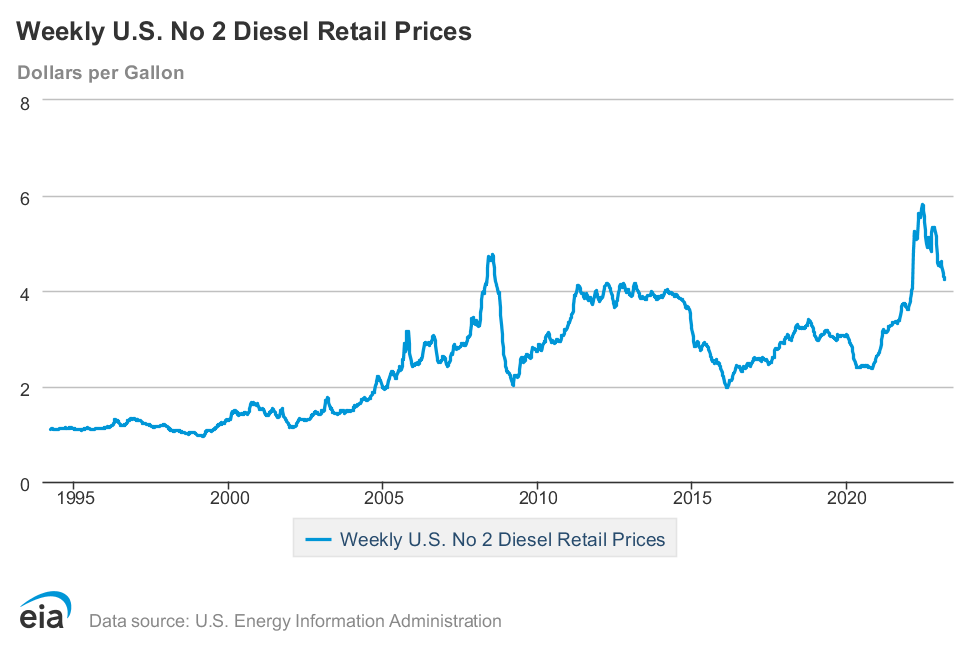

## Data Processing

In [1]:
# import necessary packages

import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [9]:
time_step = []
price_item = []

with open('/content/Weekly_U.S._No_2_Diesel_Retail_Prices.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for row in reader:
    price_item.append(float(row[1]))
    time_step.append((row[0]))

print(len(time_step), len(price_item))

series = np.array(price_item)
time = np.array(time_step)

1513 1513


In [10]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

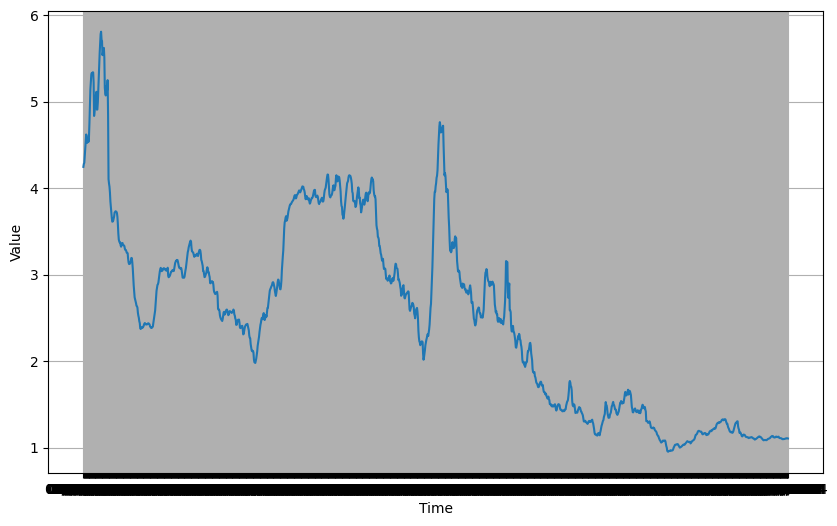

In [11]:
plt.figure(figsize=(10,6))
plot_series(time, series)

In [12]:
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)


In [13]:
    # Number of features in the dataset. We use all features as predictors to predict all features of future time steps.
    N_FEATURES = len(df.columns)

    # Normalizes the data
    data = df.values
    data = data
    data = normalize_series(data, data.min(axis=0) ,data.max(axis=0) )

    # Splits the data into training and validation sets.
    SPLIT_TIME = int(len(data) * 0.8)
    x_train = data[:SPLIT_TIME]
    x_valid = data[SPLIT_TIME:]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)


    BATCH_SIZE = 32


    # Number of past time steps based on which future observations should be predicted
    N_PAST = 10  # DO NOT CHANGE THIS

    # Number of future time steps which are to be predicted.
    N_FUTURE = 10

    # By how many positions the window slides to create a new window of observations.
    SHIFT = 1  # DO NOT CHANGE THIS

    # Code to create windowed train and validation datasets.
    train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)


In [14]:
# Get one batch of the dataset
for x_batch, y_batch in valid_set.take(1):
    # Print the shape of x_batch and y_batch
    print('x_batch shape:', x_batch.shape)
    print('y_batch shape:', y_batch.shape)


x_batch shape: (32, 10, 1)
y_batch shape: (32, 10, 1)


## Model Implementation

In [15]:
MAX_EPOCHS = 50
performance_dict = {}


In [16]:

def compile_and_fit(model, patience=2):

  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)


  ModelCheckpoint = [
      keras.callbacks.ModelCheckpoint(f"diesel_retail_{model.name}.keras",
      save_best_only=True)]

  optimizer = keras.optimizers.Adam()

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train_set, epochs=MAX_EPOCHS,
                      validation_data=valid_set,
                      callbacks=[early_stopping, ModelCheckpoint], verbose=2, batch_size = 32)

  performance_dict[f"{model.name}"] = last_val_loss = [ f"loss : {history.history['loss'][-1]}" , f"mae : {history.history['mean_absolute_error'][-1]}", f"val_loss : {history.history['val_loss'][-1]}" , f"val_mae : {history.history['val_mean_absolute_error'][-1]}" ]

  return history

In [21]:
 #### simple densely connected network

inputs = keras.Input(shape=(10,1))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

dense_model = keras.Model(inputs, outputs, name="dense_model")

In [22]:
dense_model.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 dense_3 (Dense)             (None, 10, 64)            128       
                                                                 
 dense_4 (Dense)             (None, 10, 64)            4160      
                                                                 
 dense_5 (Dense)             (None, 10, 10)            650       
                                                                 
Total params: 4,938
Trainable params: 4,938
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = compile_and_fit(dense_model)

Epoch 1/50
38/38 - 1s - loss: 0.0922 - mean_absolute_error: 0.2508 - val_loss: 0.0080 - val_mean_absolute_error: 0.0834 - 972ms/epoch - 26ms/step
Epoch 2/50
38/38 - 0s - loss: 0.0245 - mean_absolute_error: 0.1235 - val_loss: 0.0248 - val_mean_absolute_error: 0.1558 - 223ms/epoch - 6ms/step
Epoch 3/50
38/38 - 0s - loss: 0.0100 - mean_absolute_error: 0.0810 - val_loss: 0.0198 - val_mean_absolute_error: 0.1389 - 248ms/epoch - 7ms/step


In [24]:
performance_dict['dense_model']

['loss : 0.009978510439395905',
 'mae : 0.08095390349626541',
 'val_loss : 0.019800493493676186',
 'val_mae : 0.13891643285751343']

In [35]:
### lstm model

inputs = keras.Input(shape=(10,1))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=False)(x)
x = layers.Dense(N_FUTURE*N_FEATURES)(x)
outputs = layers.Reshape([N_FUTURE, N_FEATURES])(x)


lstm_model = keras.Model(inputs, outputs, name="lstm_model")

In [36]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = compile_and_fit(lstm_model, patience=8)

Epoch 1/50
38/38 - 4s - loss: 0.0750 - mean_absolute_error: 0.2272 - val_loss: 0.0139 - val_mean_absolute_error: 0.1140 - 4s/epoch - 109ms/step
Epoch 2/50
38/38 - 0s - loss: 0.0066 - mean_absolute_error: 0.0613 - val_loss: 0.0040 - val_mean_absolute_error: 0.0600 - 411ms/epoch - 11ms/step
Epoch 3/50
38/38 - 1s - loss: 0.0058 - mean_absolute_error: 0.0519 - val_loss: 0.0025 - val_mean_absolute_error: 0.0476 - 512ms/epoch - 13ms/step
Epoch 4/50
38/38 - 1s - loss: 0.0043 - mean_absolute_error: 0.0440 - val_loss: 0.0019 - val_mean_absolute_error: 0.0414 - 620ms/epoch - 16ms/step
Epoch 5/50
38/38 - 0s - loss: 0.0035 - mean_absolute_error: 0.0397 - val_loss: 0.0015 - val_mean_absolute_error: 0.0371 - 403ms/epoch - 11ms/step
Epoch 6/50
38/38 - 0s - loss: 0.0032 - mean_absolute_error: 0.0380 - val_loss: 0.0013 - val_mean_absolute_error: 0.0350 - 404ms/epoch - 11ms/step
Epoch 7/50
38/38 - 0s - loss: 0.0032 - mean_absolute_error: 0.0375 - val_loss: 0.0012 - val_mean_absolute_error: 0.0337 - 422m

In [28]:
lstm_model = keras.models.load_model("diesel_retail_lstm_model.keras")


In [29]:
performance_dict['lstm_model']

['loss : 0.0030644622165709734',
 'mae : 0.038758181035518646',
 'val_loss : 0.0006569029064849019',
 'val_mae : 0.0162078607827425']

In [ ]:
lstm_model.save("lstm_us_diesel_preices_forecatsing.h5")